In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from util.network import create_braess_network
from util.analysis import plot_social_welfare, plot_travel_time_per_route, plot_cars_per_edge, plot_cars_per_route, draw_edge_utilization, draw_latency_params, \
    plot_latency_increase_per_edge, plot_toll_per_edge
from util.tolling import update_tolls
from util.network import create_braess_network
from environment import Car, TrafficModel

In [2]:
number_of_cars = 20
number_of_steps = 20

network = create_braess_network(capacity=number_of_cars)
cars = {car_id: Car(car_id, 0, 3, anticipation_strategy='route_tolls', verbose=False) for car_id in range(number_of_cars)}

model = TrafficModel(network, cars, R=0.1, beta=1)

model.set_edge_restriction((1, 2), allowed=False)
step_stats, car_stats = model.run_single_steps(number_of_steps)

100%|██████████| 20/20 [00:00<00:00, 389.67it/s]


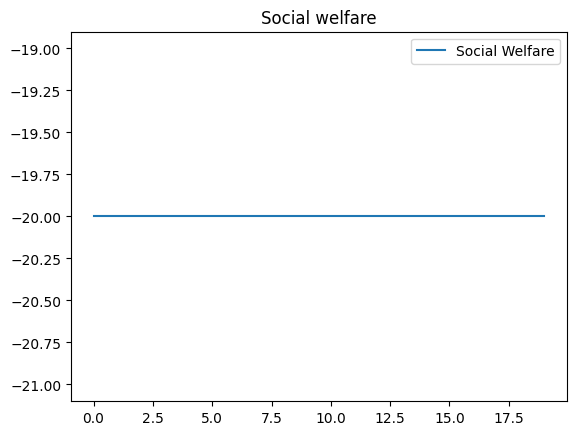

In [3]:
plot_social_welfare(step_stats)

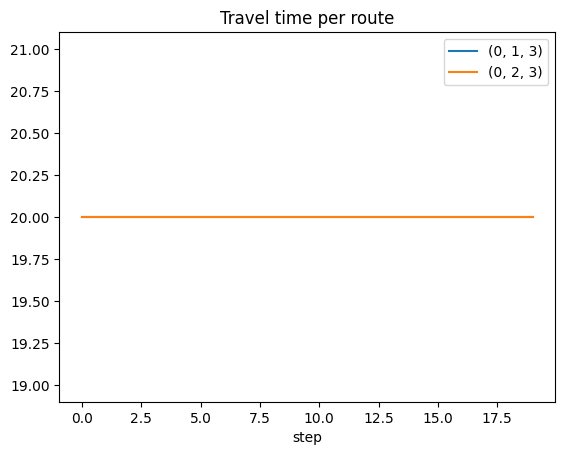

In [4]:
plot_travel_time_per_route(car_stats)

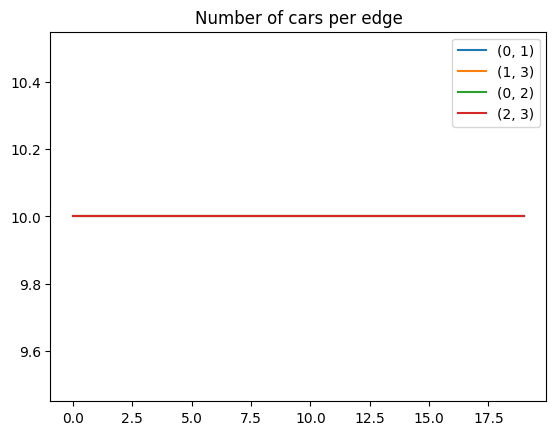

In [5]:
plot_cars_per_edge(car_stats)

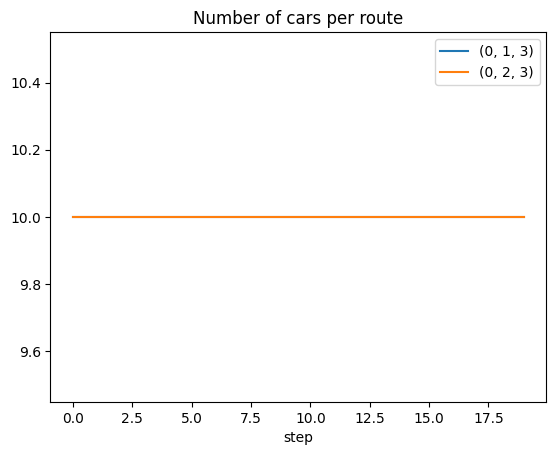

In [139]:
plot_cars_per_route(car_stats)

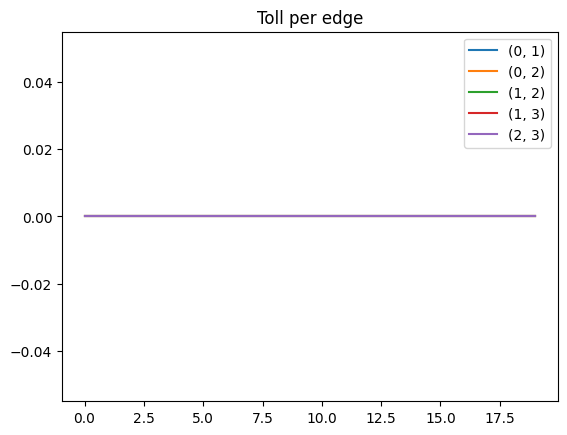

In [140]:
plot_toll_per_edge(step_stats)

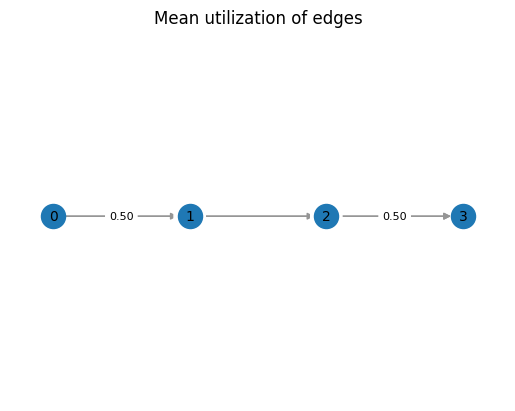

In [141]:
draw_edge_utilization(model, car_stats)

In [142]:
# draw_latency_params(model)

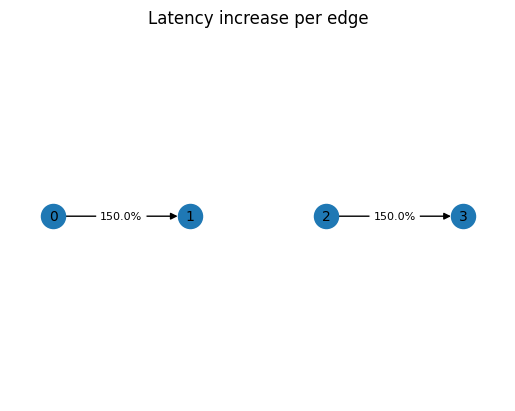

In [143]:
plot_latency_increase_per_edge(model, step_stats)

## Delta-tolling

In [ ]:
def run(model, number_of_steps, verbose=False):
    routes = {id: [] for id in model.cars}

    nx.set_edge_attributes(model.network, 0, "utilization")
    model.update_latencies()

    step_stats = []
    car_stats = []
    for step in (range if verbose else trange)(number_of_steps):
        if verbose:
            print(f"Step {step}:")
            print(
                f'Initial latency = {nx.get_edge_attributes(model.network, "latency")}'
            )

        for id, car in np.random.permutation(list(model.cars.items())):
            for edge in zip(routes[id], routes[id][1:]):
                model.decrease_utilization(edge)

            # Let agents choose a route, given the network with allowed edges only
            routes[id] = car.act(model.allowed_network, verbose=verbose)

            for edge in zip(routes[id], routes[id][1:]):
                model.increase_utilization(edge)

        step_stats.append(
            list(routes.values())
            + list(nx.get_edge_attributes(model.network, "latency").values())
            + list(nx.get_edge_attributes(model.network, "toll").values())
            + [
                nx.path_weight(model.network, route, "latency")
                for car_id, route in routes.items()
            ]
        )

        for id, car in model.cars.items():
            car_stats.append(
                {
                    "step": step,
                    "car_id": id,
                    "source": car.source,
                    "target": car.target,
                    "route": tuple(routes[id]),
                    "travel_time": nx.path_weight(model.network, routes[id], "latency"),
                }
            )

        update_tolls(model.network, beta=1, R=0.1)

    return pd.DataFrame(
        step_stats,
        columns=pd.MultiIndex.from_tuples(
            [("route", car_id) for car_id in model.cars]
            + [("latency", car_id) for car_id in model.network.edges]
            + [("travel_time", car_id) for car_id in model.cars]
        ),
    ), pd.DataFrame(car_stats)

In [ ]:
number_of_cars = 20
number_of_steps = 20

network = create_braess_network()
cars = {id: Car(0, 3) for id in range(number_of_cars)}

model = TrafficModel(network, cars)

model.set_edge_restriction((1, 2), allowed=False)
